### Kafka through the years: A computational text analysis


As a researcher with a background in literary studies, computational methods are an exciting possibility to gain insights into larger corpora of texts, as opposed to the traditional close reading of only a few. For the scope of this project, I'll be limiting myself to a few texts only, but hope to gain the skills to execute bigger analyses in the future.

In this project, we'll be looking at a corpus works by the world-famous author Franz Kafka. While Kafka's writing is known to be surrealistic, many people interpret his works as reflective of his personal experiences and psyche. This project aims to answer the following questions:

- What topics did Kafka write about most often?
- What sentiments do his texts show? Do they change throughout the years?
- What references to specific entities like organizations, places and events – real or fictional – can be found?

This project hopes to gain insight into the evolution of Kafka's writing and possible connections to his personal experiences by using computational methods to make exploring several of his works at once possible.

In [ ]:
!pip install -U -q gensim mpld3 python-Levenshtein pyldavis
!pip install wordcloud
!pip install textblob

In [ ]:
!pip install spacy

In [ ]:
#necessary due to compatibility issues with newer version
!pip install 'pydantic< 2.0'

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
import codecs
import string

import gensim
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

We'll be working with a corpus of 12 works by Franz Kafka, and doing some NLP with the whole corpus as well as focusing on a few singular ones:
- "Amerika" ("Amerika", written between 1911-1914), 
- "Die Verwandlung" ("The Metamorphosis", written 1912),
- "In der Strafkolonie" ("In the Penal Colony", written 1914),
- "Der Prozess" ("The Trial", written 1914-1915),
- "Das Schloss" ("The Castle", written 1922)
- "Der Bau" ("The Burrow", written 1923-1924)

#### Let's import the data and clean it! We'll be importing each file separately, so we can easily perform NLP on the individual texts later.

In [28]:
#downloading models and datasets needed for data cleaning
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/Clara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Clara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Clara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
#defining a cleaning function:
import spacy
from spacy.lang.de.stop_words import STOP_WORDS
import string

#loading the german spaCy model
nlp = spacy.load('de_core_news_sm')

def clean_text(file_path):
    #opening file and specifying encoding
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        text = file.read()

    #removing quotation marks
    text = text.replace('»', '').replace('«', '')

    #removing special characters and numbers
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    #lowercasing
    text = text.lower()

    #processing text with spaCy (needed to support lemmatization for german text data)
    doc = nlp(text)

    #lemmatization and removing stopwords
    lemmatized_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]
    
    #putting tokens back into a string
    cleaned_text =  ' '.join(lemmatized_tokens)
    
    return cleaned_text

#let's try it on one of the texts:
the_judgement = clean_text('data/Das_Urteil.txt')
print(the_judgement)

Fräulein Felice b 



 Sonntagvormittag schön Frühjahr Georg Bendemann jung Kaufmann sitzen Privatzimmer Stock niedrig leichtgebaut Haus entlang Flusses lang Reihe fast Höhe Färbung unterscheiden hinzogen Brief Ausland befindenden Jugendfreund beenden verschließen spielerisch Langsamkeit Ellbogen Schreibtisch stützen Fenster Fluß Brücke anhöh Ufer schwach Grün 

 dachen Freund Fortkommen Hause unzufrieden Rußland förmlich flüchten betreiben Geschäft Petersburg anfangs anlassen lang stocken scheinen Freund selten werdend Besuch klagen arbeiten Fremde nutzlos fremdartig Vollbart verdecken kinderjahren wohlbekannt Gesicht gelb Hautfarbe entwickelnd Krankheit hinzudeuten scheinen erzählen Verbindung dortig Kolonie Landsleute fast gesellschaftlich Verkehr einheimisch Familie richten endgültig Junggesellentum 

 Manne schreiben offenbar verrennen bedauern helfen raten Hause Existenz hierher verlegen alt freundschaftlich Beziehung aufnehmen   wofür Hindernis bestehen   übrig Hilfe Freund vert

It worked! Let's repeat the process for the other texts (this time, without printing everything).

In [45]:
amerika = clean_text('data/Amerika.txt')

In [46]:
aphorisms = clean_text('data/Aphorismen.txt')

In [47]:
the_gallery = clean_text('data/Auf_der_Galerie.txt')

In [48]:
blumfeld = clean_text('data/Blumfeld,_ein_aelterer_Junggeselle.txt')

In [49]:
letter_to_father = clean_text('data/Brief_an_den_Vater.txt')

In [50]:
the_castle = clean_text('data/Das_Schloss.txt')

In [51]:
the_burrow = clean_text('data/Der_Bau.txt')

In [52]:
the_metamorphosis = clean_text('data/Die_Verwandlung.txt')

In [53]:
the_warden = clean_text('data/Der_Gruftwaechter.txt')

In [54]:
the_trial = clean_text('data/Der_Prozess.txt')

In [55]:
penal_colony = clean_text('data/In_der_Strafkolonie.txt')

Let's combine everything into one string so we can do some basic explorations:

In [70]:
all_texts = amerika + the_judgement + the_metamorphosis + penal_colony + the_trial + blumfeld + the_warden + aphorisms + letter_to_father + the_gallery + the_castle + the_burrow
#transform into list of words
list_words = all_texts.split()
print(list_words[0:30])

['Heizer', 'sechzehnjährig', 'Karl', 'Roßmann', 'arm', 'Eltern', 'Amerika', 'schicken', 'dienstmädchen', 'verführen', 'Kind', 'bekommen', 'langsam', 'geworden', 'Schiff', 'Hafen', 'New', 'York', 'Einfuhr', 'erblicken', 'längst', 'beobachtet', 'Statue', 'Freiheitsgöttin', 'plötzlich', 'stark', 'geworden', 'Sonnenlicht', 'arm', 'Schwert']


In [19]:
#finding out the words Kafka most commonly uses
from collections import Counter

freqdist = Counter(list_words)

In [20]:
freqdist.most_common(40)

[('k', 2241),
 ('Karl', 1201),
 ('lassen', 610),
 ('Herr', 597),
 ('wissen', 589),
 ('müssen', 583),
 ('Hand', 567),
 ('sehen', 553),
 ('Tür', 516),
 ('fragen', 510),
 ('stehen', 501),
 ('scheinen', 490),
 ('Mann', 455),
 ('fast', 405),
 ('bleiben', 401),
 ('gewiß', 400),
 ('glauben', 389),
 ('halten', 379),
 ('Frieda', 379),
 ('sagen', 371),
 ('Frau', 367),
 ('hören', 342),
 ('Arbeit', 340),
 ('rufen', 338),
 ('Vater', 330),
 ('liegen', 322),
 ('denken', 311),
 ('sprechen', 307),
 ('Klamm', 303),
 ('Auge', 293),
 ('finden', 292),
 ('kommen', 291),
 ('Wort', 287),
 ('sogar', 277),
 ('zeigen', 274),
 ('suchen', 255),
 ('eigentlich', 250),
 ('Sache', 249),
 ('Gregor', 248),
 ('wahrscheinlich', 247)]

In [21]:
#importing wordcloud
from wordcloud import WordCloud

#joining all the words into a string
cleaned = ' '.join(list_words)
wordcloud = WordCloud().generate(cleaned)

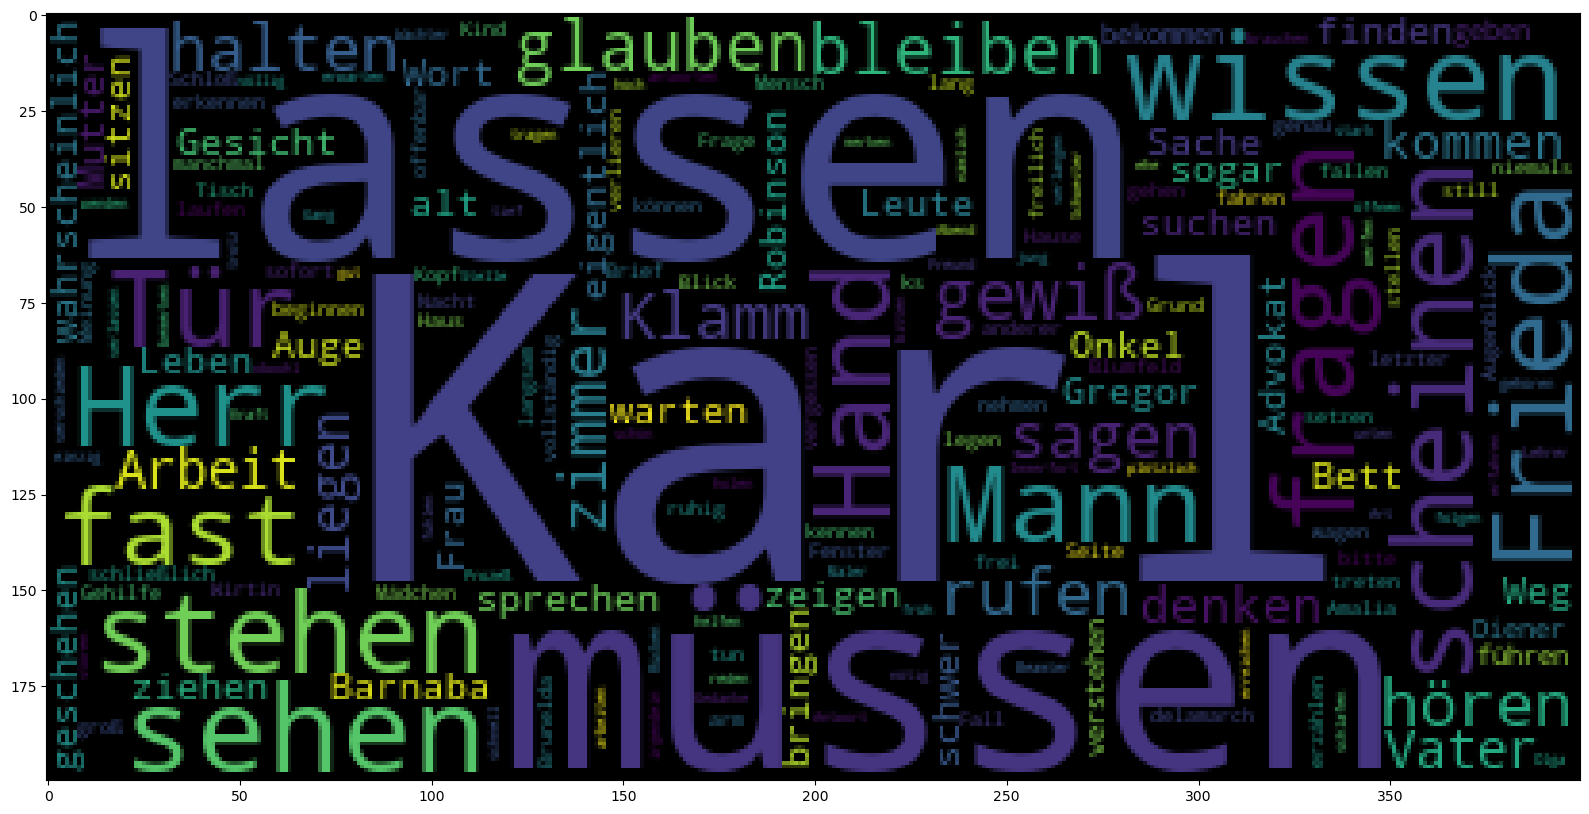

In [22]:
#creating wordcloud
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

The most common words are mostly verbs like "let", "must", "seem", "know, "ask", "think", "see" indicate a focus on human actions and perceptions. Kafka's works often explore existential themes.
The high frequency of the word "work" reflects how these themes are often intertwined with institutional or corporate settings. The words "understand", "think", "know", "believe" also reflect Kafka's dealings with our inner state of mind. 

#### Finding the number of unique words Kafka uses:

In [23]:
unique_words_set = set(list_words)
number_of_unique_words = len(unique_words_set)
print("Number of unique words:", number_of_unique_words)

Number of unique words: 19969


#### Finding bigrams using pointwise mutual information: 

In [24]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(list_words)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

Theater Oklahoma
New York
rechts links
fräulein bürstn
fügen hinzu
fräulein Bürstner
worum handeln
fräulein Montag
Fräulein Montag
Fräulein Bürstner
Soldat verurteilter
gesenkt Kopf
Frau grubach
Anspruch nehmen
paar Schritt
Herr Pollunder
Herr Green
schütteln Kopf
Ordnung bringen
Herr Samsa
Herr Pollunders
halb Stunde
Verbindung Schloß
Frau oberköchin
paar Stunde
Herr Landvermesser
paar Wort
Herr Prokurist
Gregor zimm
jung Mann


#### Finding trigrams using pointwise mutual information:

In [25]:
max_items = 30
freq_min_t = 4
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(list_words)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

wissen worum handeln
fragt Herr Pollunder
paar Wort sprechen
fahren k fort
k Frau grubach
Herr Pollunder Karl
fassen Karl Hand
Frau Wirtin k


A lot of the trigrams contain the singular letter "k" – this is since both of the longest texts in the corpus, "The Trial" and "The Castle" contain a main protagonist who is referred to as "K.". It's interesting that "wissen worum handeln" – likely from "wissen worum es sich handelt" which I would roughly translate to "know what something is about" – is at the top of the list. 

### Let's get into our research questions now. We will start by applying topic modelling to our entire corpus:

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize


#organizing texts into documents
documents = [amerika, aphorisms, blumfeld, the_judgement, letter_to_father, the_castle, the_metamorphosis, penal_colony, the_trial, the_gallery, the_burrow, the_metamorphosis, the_warden]

#tokenizing the documents
tokenized_documents = [word_tokenize(doc.lower()) for doc in documents]

#creating dictionary
dictionary = corpora.Dictionary(tokenized_documents)

#filtering out low- and high-frequency words, which will improve topic quality, as described in this paper: https://ceur-ws.org/Vol-2723/long7.pdf
dictionary.filter_extremes(no_below=2, no_above=0.5)

#creating corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]




In [27]:
#running the LDA model, a very popular model used for topic modeling
Lda = gensim.models.ldamodel.LdaModel

ldamodel = Lda(corpus, num_topics=5, id2word = dictionary, passes=50)

In [28]:
print(ldamodel.print_topics(num_topics=5, num_words=15))

[(0, '0.050*"gregor" + 0.021*"schwester" + 0.009*"offizier" + 0.009*"reisende" + 0.008*"prokurist" + 0.007*"bau" + 0.006*"samsa" + 0.005*"eltern" + 0.005*"kommandant" + 0.005*"soldat" + 0.004*"bedienerin" + 0.004*"kanapee" + 0.003*"zimmerherrer" + 0.003*"gret" + 0.003*"reisend"'), (1, '0.034*"wächter" + 0.005*"hoheit" + 0.004*"erkenntnis" + 0.004*"friedrich" + 0.003*"sünd" + 0.003*"ungeduld" + 0.003*"gegner" + 0.003*"wahr" + 0.003*"dauernd" + 0.003*"streben" + 0.003*"gruft" + 0.002*"arzt" + 0.002*"unendlich" + 0.002*"dreißig" + 0.002*"geistig"'), (2, '0.088*"k" + 0.017*"frieda" + 0.009*"advokat" + 0.007*"schloß" + 0.006*"ks" + 0.006*"gehilfe" + 0.005*"beamter" + 0.005*"prozeß" + 0.005*"fräulein" + 0.004*"lehrer" + 0.004*"gericht" + 0.004*"onkel" + 0.004*"wirt" + 0.003*"kaufmann" + 0.003*"partei"'), (3, '0.097*"karl" + 0.020*"robinson" + 0.011*"onkel" + 0.007*"koffer" + 0.005*"hotel" + 0.005*"straße" + 0.005*"geld" + 0.004*"student" + 0.003*"polizeimann" + 0.003*"balkon" + 0.003*"fragt"

Let's try interpreting these topics:

- 0: This topic includes words like "Koffer" ("Suitcase"), "Hotel", "Schiff" ("ship") and seems to focus on traveling/adventure. A lot of these words are likely from the novel "Amerika".
- 1: This topic seems to focus on judicial themes: "Advokat" (Lawyer), "Prozeß" ("Trial"), "Gericht" ("court") etc. are included in this topic. This makes sense since several of Kafka's works (The Trial, In The Penal Colony) deal with these themes. 
- 2: Here we see words like "heiraten" ("to marry"), "erziehung" ("education" or "upbringing"), "Schuldbewußtsein" ("sense of guilt"),  indicating a focus on personal relationships and or moral dilemmas.
- 3: Topic 3 contains words like "Eltern" ("parents"), "Kanapee" ("Sofa"), "Schwester" ("sister"), "Möbel" ("furniture") etc., indicating a domestic setting and family dynamics.
- 4: : Pretty much all of these words seem to come from the story "In the Penal Colony": "Reisender" ("Traveler"), "Soldat" (Soldier), "Apparat" ("Machine") and so on. However, we did filter our words so they have to appear in at least two documents, so they must appear in other texts as well. 

Overall, the topics show common themes in Kafka's writing, but the topics correspond more to the individual texts than giving insight into the corpus as a whole. This is possibly due to 
- the corpus being quite small
- longer texts dominating the topics.

We can't remedy these issues in the scope of this project, but on a positive note, the topic quality seems good – the topics don't consist of cohesion elements as is often an issue with literary texts, but are actually meaningful and interpretable. We can assume that when applied to a larger corpus, topic modelling could be quite useful.

### Let's try doing a Sentiment Analysis on some of these texts!

We will be focusing on the following works:
- "Amerika" ("Amerika", written between 1911-1914), 
- "Die Verwandlung" ("The Metamorphosis", written 1912),
- "In der Strafkolonie" ("In the Penal Colony", written 1914),
- "Der Prozess" ("The Trial", written 1914-1915),
- "Das Schloss" ("The Castle", written 1922)
- "Der Bau" ("The Burrow", written 1923-1924)


To do this, we will need to re-import our text files and analyze them while this time leaving the sentences intact.

In [29]:
nltk.download('vader_lexicon')
#this model is optimized for english! according to some research I did, it still works quite well for german. there is a german version of VADER, but so far, I couldn't get it to work – we might be able to further down the line, but let's use the english version for now to get at least a rough idea on the sentiment.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Clara/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [64]:
from nltk import sent_tokenize

#intializing vader analyzer
sia = SentimentIntensityAnalyzer()

#defining function to apply vader to texts
def analyze_sentiments_from_file(file_path):
    neg_scores = []
    neu_scores = []
    pos_scores = []
    compound_scores = []

    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        text = file.read()  #reading text from file

        #tokenizing into sentences
        sentences = nltk.sent_tokenize(text, language='german')

        #analyzing and collecting sentiment scores for each sentence
        for sentence in sentences:
            scores = sia.polarity_scores(sentence)
            neg_scores.append(scores['neg'])
            neu_scores.append(scores['neu'])
            pos_scores.append(scores['pos'])
            compound_scores.append(scores['compound'])

    #calculating overall average sentiment scores
    overall_avg_neg = sum(neg_scores) / len(neg_scores)
    overall_avg_neu = sum(neu_scores) / len(neu_scores)
    overall_avg_pos = sum(pos_scores) / len(pos_scores)
    overall_avg_compound = sum(compound_scores) / len(compound_scores)

    return {
        'avg_neg': overall_avg_neg,
        'avg_neu': overall_avg_neu,
        'avg_pos': overall_avg_pos,
        'avg_compound': overall_avg_compound
    }

#### Let's apply the function to our texts:

In [57]:
analyze_sentiments_from_file('data/Amerika.txt')

{'avg_neg': 0.09751563845050219,
 'avg_neu': 0.8974774748923965,
 'avg_pos': 0.0050051649928263995,
 'avg_compound': -0.33770648493543176}

In [32]:
analyze_sentiments_from_file('data/Die_Verwandlung.txt')

{'avg_neg': 0.14063414634146343,
 'avg_neu': 0.8569131097560972,
 'avg_pos': 0.002446646341463414,
 'avg_compound': -0.4841815548780489}

In [33]:
analyze_sentiments_from_file('data/In_der_Strafkolonie.txt')

{'avg_neg': 0.12316204690831557,
 'avg_neu': 0.8740383795309156,
 'avg_pos': 0.0028038379530916837,
 'avg_compound': -0.3608733475479751}

In [34]:
analyze_sentiments_from_file('data/Der_Prozess.txt')

{'avg_neg': 0.10229911323328784,
 'avg_neu': 0.8926995225102322,
 'avg_pos': 0.005002046384720325,
 'avg_compound': -0.3304536834924884}

In [35]:
analyze_sentiments_from_file('data/Das_Schloss.txt')

{'avg_neg': 0.09923983842464058,
 'avg_neu': 0.8986119666750801,
 'avg_pos': 0.0021492047462761932,
 'avg_compound': -0.35149747538500203}

In [36]:
analyze_sentiments_from_file('data/Der_Bau.txt')

{'avg_neg': 0.07721361502347421,
 'avg_neu': 0.9221361502347416,
 'avg_pos': 0.0006525821596244132,
 'avg_compound': -0.3169427230046953}

#### Let's visualize these scores in a plot!

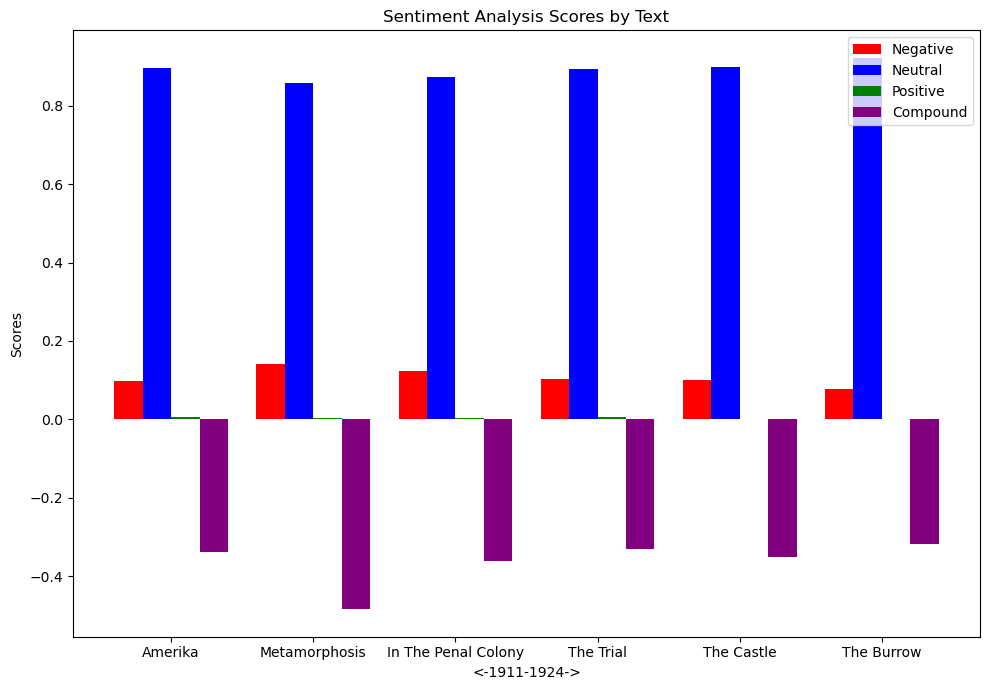

In [37]:
texts = ['Amerika', 'Metamorphosis', 'In The Penal Colony', 'The Trial', 'The Castle', 'The Burrow']
neg_scores = [0.09751563845050219,0.14063414634146343, 0.12316204690831557, 0.10229911323328784,0.09923983842464058, 0.07721361502347421]
neu_scores = [0.8974774748923965,0.8569131097560972,0.8740383795309156,0.8926995225102322,0.8986119666750801, 0.9221361502347416 ]
pos_scores = [0.0050051649928263995, 0.002446646341463414, 0.0028038379530916837, 0.005002046384720325, 0.0021492047462761932, 0.0006525821596244132]
compound_scores = [-0.33770648493543176, -0.4841815548780489, -0.3608733475479751, -0.3304536834924884, -0.35149747538500203,  -0.3169427230046953]

plt.figure(figsize=(10, 7))

indices = range(len(texts))
width = 0.2

#plotting the bars for each score
plt.bar(indices, neg_scores, width=width, label='Negative', color='red')
plt.bar([i + width for i in indices], neu_scores, width=width, label='Neutral', color='blue')
plt.bar([i + width * 2 for i in indices], pos_scores, width=width, label='Positive', color='green')
plt.bar([i + width * 3 for i in indices], compound_scores, width=width, label='Compound', color='purple')

#labels and title
plt.xlabel('<-1911-1924->')
plt.ylabel('Scores')
plt.title('Sentiment Analysis Scores by Text')

#adding names of texts
plt.xticks([i + width * 1.5 for i in indices], texts)

#legend
plt.legend()

#displaying plot
plt.tight_layout()
plt.show()

All of the texts have extremely low positive scores, and show a slight negative sentiment, with "The Metamorphosis" having the highest negative score. Overall, all the compound scores are negative, which is not surprising considering Kafka's often somber writing and themes. There's no trend to be seen over time. It's important to consider that literature is complex and might convey sentiment in a way that can not be measured with these methods. 

Out of curiosity, I wanted to see if Kafka's letters to Milena – non-fictional "love letters", after all – would show a similar sentiment. They were not part of the corpus I used, but I found a pdf file that I will use to extract the text data from:

In [38]:
!pip install pdfplumber

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [89]:
#modifying code from before:
import pdfplumber

#defining function
def analyze_sentiments_from_pdf(pdf_file_path):
    neg_scores = []
    neu_scores = []
    pos_scores = []
    compound_scores = []

    #extracting text from pdf
    with pdfplumber.open(pdf_file_path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text()

        sentences = nltk.sent_tokenize(text, language='german')

        for sentence in sentences:
            scores = sia.polarity_scores(sentence)
            neg_scores.append(scores['neg'])
            neu_scores.append(scores['neu'])
            pos_scores.append(scores['pos'])
            compound_scores.append(scores['compound'])

    overall_avg_neg = sum(neg_scores) / len(neg_scores)
    overall_avg_neu = sum(neu_scores) / len(neu_scores)
    overall_avg_pos = sum(pos_scores) / len(pos_scores)
    overall_avg_compound = sum(compound_scores) / len(compound_scores)

    return {
        'avg_neg': overall_avg_neg,
        'avg_neu': overall_avg_neu,
        'avg_pos': overall_avg_pos,
        'avg_compound': overall_avg_compound
    }


pdf_file_path = 'data/BriefeAnMilena.pdf'
sentiment_scores = analyze_sentiments_from_pdf(pdf_file_path)
print(sentiment_scores)


{'avg_neg': 0.07418833283979863, 'avg_neu': 0.9228658572697668, 'avg_pos': 0.0023532721350310926, 'avg_compound': -0.24044006514657448}


#### Lets's add this to the plot!

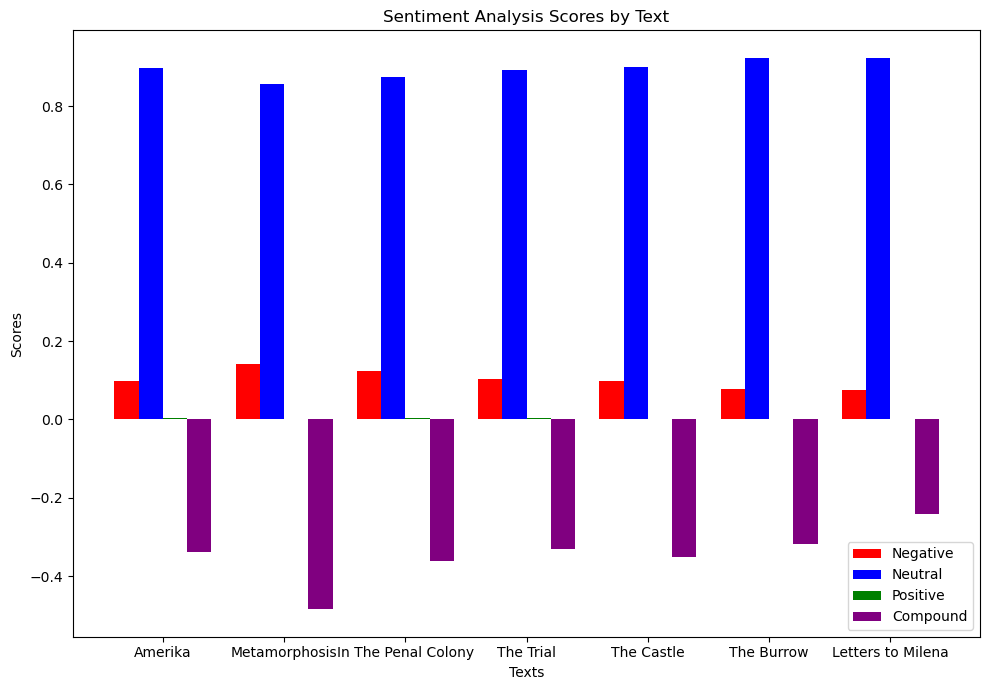

In [40]:
texts = ['Amerika', 'Metamorphosis', 'In The Penal Colony', 'The Trial', 'The Castle', 'The Burrow', 'Letters to Milena']
neg_scores = [0.09751563845050219,0.14063414634146343, 0.12316204690831557, 0.10229911323328784,0.09923983842464058, 0.07721361502347421, 0.07418833283979863]
neu_scores = [0.8974774748923965,0.8569131097560972,0.8740383795309156,0.8926995225102322,0.8986119666750801, 0.9221361502347416, 0.9228658572697668 ]
pos_scores = [0.0050051649928263995, 0.002446646341463414, 0.0028038379530916837, 0.005002046384720325, 0.0021492047462761932, 0.0006525821596244132,0.0023532721350310926 ]
compound_scores = [-0.33770648493543176, -0.4841815548780489, -0.3608733475479751, -0.3304536834924884, -0.35149747538500203,  -0.3169427230046953, -0.24044006514657448]

plt.figure(figsize=(10, 7))

indices = range(len(texts))
width = 0.2

#plotting the bars for each score
plt.bar(indices, neg_scores, width=width, label='Negative', color='red')
plt.bar([i + width for i in indices], neu_scores, width=width, label='Neutral', color='blue')
plt.bar([i + width * 2 for i in indices], pos_scores, width=width, label='Positive', color='green')
plt.bar([i + width * 3 for i in indices], compound_scores, width=width, label='Compound', color='purple')

#labels and title
plt.xlabel('Texts')
plt.ylabel('Scores')
plt.title('Sentiment Analysis Scores by Text')

#adding names of texts
plt.xticks([i + width * 1.5 for i in indices], texts)

#legend
plt.legend()

#displaying plot
plt.tight_layout()
plt.show()

As we can see, Kafka's Letters to Milena do end up being less negative than all of our other texts.

Let's try some Emotion Detection with the NRC lexicon instead. We can use the German lexicon for this: 

In [41]:
#installing and importing the NRC lexicon
!pip install NRClex
import nrclex
from nrclex import NRCLex

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [60]:
nrc_lexicon = {}

#loading german version 
with open('/Users/Clara/Downloads/NRC-Emotion-Lexicon/OneFilePerLanguage/German-NRC-EmoLex.txt', 'r') as file:
    next(file)  
    for line in file:
        column = line.strip().split('\t')
        
        #extracting german words
        german_word = column[-1]
        #extracting emotions
        emotions = column[1:-1]  

        if german_word not in nrc_lexicon:
            nrc_lexicon[german_word] = {}

        #associating each word with its emotions
        for i, emotion in enumerate(["anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"]):
            nrc_lexicon[german_word][emotion] = int(emotions[i])


print(nrc_lexicon['abscheulich'])  #testing with the word "abscheulich" ("disgusting")


{'anger': 1, 'anticipation': 0, 'disgust': 1, 'fear': 1, 'joy': 0, 'negative': 1, 'positive': 0, 'sadness': 1, 'surprise': 0, 'trust': 0}


In [61]:
#function for identifying and counting emotions for words in a sentence
def count_emotions_in_text(text, nrc_lexicon):
    emotion_counts = {emotion: 0 for emotion in list(nrc_lexicon.values())[0].keys()}
    for word in word_tokenize(text):
        if word in nrc_lexicon:
            for emotion in nrc_lexicon[word]:
                emotion_counts[emotion] += nrc_lexicon[word][emotion]
    return emotion_counts

In [62]:
#testing function on of the texts
amerika_emotions = count_emotions_in_text(amerika, nrc_lexicon)
print(amerika_emotions)

{'anger': 835, 'anticipation': 972, 'disgust': 579, 'fear': 865, 'joy': 822, 'negative': 2217, 'positive': 3332, 'sadness': 883, 'surprise': 493, 'trust': 1795}


In [63]:
#applying function to all texts
text_emotions = [amerika, the_metamorphosis, penal_colony, the_trial, the_castle, the_burrow]

all_emotion_analysis_results = []

for text in text_emotions:
    emotion_analysis_results = count_emotions_in_text(text, nrc_lexicon)
    
    all_emotion_analysis_results.append(emotion_analysis_results)
    
print(all_emotion_analysis_results)

[{'anger': 835, 'anticipation': 972, 'disgust': 579, 'fear': 865, 'joy': 822, 'negative': 2217, 'positive': 3332, 'sadness': 883, 'surprise': 493, 'trust': 1795}, {'anger': 191, 'anticipation': 315, 'disgust': 122, 'fear': 229, 'joy': 261, 'negative': 660, 'positive': 745, 'sadness': 373, 'surprise': 131, 'trust': 407}, {'anger': 137, 'anticipation': 124, 'disgust': 81, 'fear': 167, 'joy': 88, 'negative': 285, 'positive': 468, 'sadness': 105, 'surprise': 73, 'trust': 292}, {'anger': 779, 'anticipation': 878, 'disgust': 604, 'fear': 989, 'joy': 527, 'negative': 2013, 'positive': 2725, 'sadness': 748, 'surprise': 430, 'trust': 1494}, {'anger': 1099, 'anticipation': 1263, 'disgust': 811, 'fear': 1170, 'joy': 1011, 'negative': 2988, 'positive': 4135, 'sadness': 1408, 'surprise': 693, 'trust': 2299}, {'anger': 156, 'anticipation': 214, 'disgust': 81, 'fear': 221, 'joy': 115, 'negative': 404, 'positive': 474, 'sadness': 169, 'surprise': 85, 'trust': 212}]


In [79]:
#sorting the data:

data = [
    [{'anger': 835, 'anticipation': 972, 'disgust': 579, 'fear': 865, 'joy': 822, 'negative': 2217, 'positive': 3332, 'sadness': 883, 'surprise': 493, 'trust': 1795}],
    [{'anger': 191, 'anticipation': 315, 'disgust': 122, 'fear': 229, 'joy': 261, 'negative': 660, 'positive': 745, 'sadness': 373, 'surprise': 131, 'trust': 407}],
    [{'anger': 137, 'anticipation': 124, 'disgust': 81, 'fear': 167, 'joy': 88, 'negative': 285, 'positive': 468, 'sadness': 105, 'surprise': 73, 'trust': 292}],
    [{'anger': 779, 'anticipation': 878, 'disgust': 604, 'fear': 989, 'joy': 527, 'negative': 2013, 'positive': 2725, 'sadness': 748, 'surprise': 430, 'trust': 1494}],
    [{'anger': 1099, 'anticipation': 1263, 'disgust': 811, 'fear': 1170, 'joy': 1011, 'negative': 2988, 'positive': 4135, 'sadness': 1408, 'surprise': 693, 'trust': 2299}],
    [{'anger': 156, 'anticipation': 214, 'disgust': 81, 'fear': 221, 'joy': 115, 'negative': 404, 'positive': 474, 'sadness': 169, 'surprise': 85, 'trust': 212}]
]

anger_list = []
anticipation_list = []
disgust_list = []
fear_list = []
joy_list = []
negative_list = []
positive_list = []
sadness_list = []
surprise_list = []
trust_list = []

for sublist in data:
    for dictionary in sublist:
        anger_list.append(dictionary['anger'])
        anticipation_list.append(dictionary['anticipation'])
        disgust_list.append(dictionary['disgust'])
        fear_list.append(dictionary['fear'])
        joy_list.append(dictionary['joy'])
        negative_list.append(dictionary['negative'])
        positive_list.append(dictionary['positive'])
        sadness_list.append(dictionary['sadness'])
        surprise_list.append(dictionary['surprise'])
        trust_list.append(dictionary['trust'])

#printing the sorted lists
print("Anger List:", anger_list)
print("Anticipation List:", anticipation_list)
print("Disgust List:", disgust_list)
print("Fear List:", fear_list)
print("Joy List:", joy_list)
print("Negative List:", negative_list)
print("Positive List:", positive_list)
print("Sadness List:", sadness_list)
print("Surprise List:", surprise_list)
print("Trust List:", trust_list)


Anger List: [835, 191, 137, 779, 1099, 156]
Anticipation List: [972, 315, 124, 878, 1263, 214]
Disgust List: [579, 122, 81, 604, 811, 81]
Fear List: [865, 229, 167, 989, 1170, 221]
Joy List: [822, 261, 88, 527, 1011, 115]
Negative List: [2217, 660, 285, 2013, 2988, 404]
Positive List: [3332, 745, 468, 2725, 4135, 474]
Sadness List: [883, 373, 105, 748, 1408, 169]
Surprise List: [493, 131, 73, 430, 693, 85]
Trust List: [1795, 407, 292, 1494, 2299, 212]


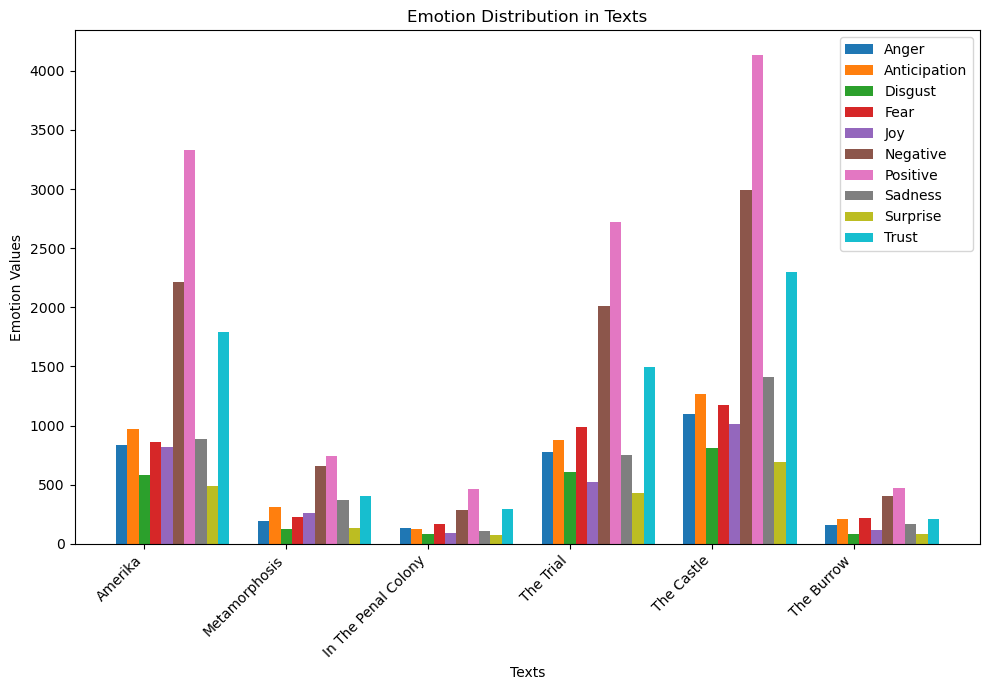

In [85]:
#modifying code from before

texts = ['Amerika', 'Metamorphosis', 'In The Penal Colony', 'The Trial', 'The Castle', 'The Burrow']
anger_list = [835, 191, 137, 779, 1099, 156]
anticipation_list = [972, 315, 124, 878, 1263, 214]
disgust_list = [579, 122, 81, 604, 811, 81]
fear_list = [865, 229, 167, 989, 1170, 221]
joy_list = [822, 261, 88, 527, 1011, 115]
negative_list = [2217, 660, 285, 2013, 2988, 404]
positive_list = [3332, 745, 468, 2725, 4135, 474]
sadness_list = [883, 373, 105, 748, 1408, 169]
surprise_list = [493, 131, 73, 430, 693, 85]
trust_list = [1795, 407, 292, 1494, 2299, 212]

plt.figure(figsize=(10, 7))

bar_width = 0.08
index = np.arange(len(texts))

plt.bar(index - 2*bar_width, anger_list, bar_width, label='Anger')
plt.bar(index - bar_width, anticipation_list, bar_width, label='Anticipation')
plt.bar(index, disgust_list, bar_width, label='Disgust')
plt.bar(index + bar_width, fear_list, bar_width, label='Fear')
plt.bar(index + 2*bar_width, joy_list, bar_width, label='Joy')
plt.bar(index + 3*bar_width, negative_list, bar_width, label='Negative')
plt.bar(index + 4*bar_width, positive_list, bar_width, label='Positive')
plt.bar(index + 5*bar_width, sadness_list, bar_width, label='Sadness')
plt.bar(index + 6*bar_width, surprise_list, bar_width, label='Surprise')
plt.bar(index + 7*bar_width, trust_list, bar_width, label='Trust')

#adding labels and text names
plt.xlabel('Texts')
plt.ylabel('Emotion Values')
plt.title('Emotion Distribution in Texts')
plt.xticks(index, texts, rotation=45, ha='right')
plt.legend()

#showing the plot
plt.tight_layout()
plt.show()

This graph shows the absolute sentiment scores of each text. Since the texts differ in length, they are hard to compare. It might be better to calculate percentages in order to really be able to compare the texts to eachother: 

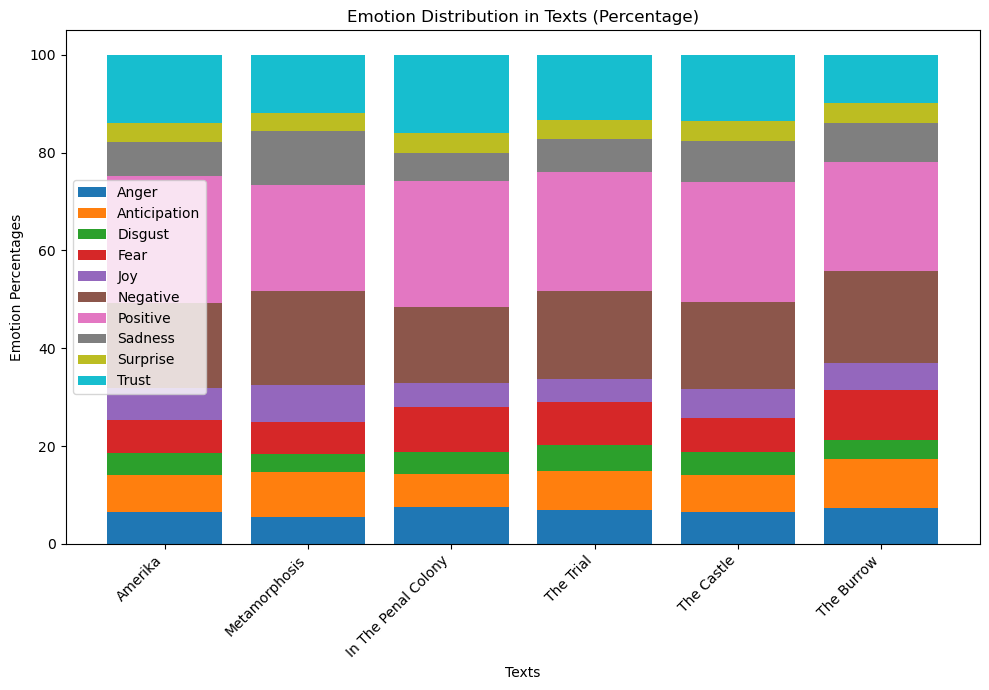

In [65]:
#modifying code from before
texts = ['Amerika', 'Metamorphosis', 'In The Penal Colony', 'The Trial', 'The Castle', 'The Burrow']
emotion_lists = {
    'Anger': [835, 191, 137, 779, 1099, 156],
    'Anticipation': [972, 315, 124, 878, 1263, 214],
    'Disgust': [579, 122, 81, 604, 811, 81],
    'Fear': [865, 229, 167, 989, 1170, 221],
    'Joy': [822, 261, 88, 527, 1011, 115],
    'Negative': [2217, 660, 285, 2013, 2988, 404],
    'Positive': [3332, 745, 468, 2725, 4135, 474],
    'Sadness': [883, 373, 105, 748, 1408, 169],
    'Surprise': [493, 131, 73, 430, 693, 85],
    'Trust': [1795, 407, 292, 1494, 2299, 212]
}

#calculating total scores for each text
total_scores = [sum(scores) for scores in zip(*emotion_lists.values())]

#calculating percentages for each text
percentage_lists = {emotion: [score / total * 100 for score, total in zip(emotion_lists[emotion], total_scores)] for emotion in emotion_lists}

plt.figure(figsize=(10, 7))

bar_width = 0.8
index = np.arange(len(texts))

bottom = np.zeros(len(texts))
for emotion in emotion_lists:
    plt.bar(index, percentage_lists[emotion], bar_width, label=emotion, bottom=bottom)
    bottom += percentage_lists[emotion]

plt.xlabel('Texts')
plt.ylabel('Emotion Percentages')
plt.title('Emotion Distribution in Texts (Percentage)')
plt.xticks(index, texts, rotation=45, ha='right')
plt.legend()

#showing the plot
plt.tight_layout()
plt.show()


The sentiment detected by the NRC lexicon is much more positive than the one detected by Vader, but some things are consistent:
- "The Metamorphosis" is the most negative text of all of them.
- "Amerika" and "The Trial" have higher positive sentiments compared to the other texts. 

Let's look at our results a bit more closely:
- "The Metamorphosis" has the highest "sadness" score by far. The text deals with isolation and rejection by family members and society, so this makes sense. I am surprised the "disgust" score isn't higher, seeing as this is an emotion often felt by the family members of the protagonist. 
- The high positive sentiment of "In The Penal Colony" is surprising considering the violent themes (TW!) that are dealt with in the book. However, that words used to express said violence aren't explicitly negative – the text refers to the machine used to execute prisoners simply as "machine" and to the method of torturing, engraving writing into the skin of said prisoners, as "writing" and "text". This might be why the lexicon is not able to pick up what should be a very negative sentiment. It could also be that the lexicon scores words like "traveller" and "journey", that appear extremely often, very positively. It does, however, do well at detecting the anger and the fear that is felt by characters in the text.
- Similarly, the lexicon detects a lot of fear in "The Trial", which makes sense as the protagonist is going through a legal trial and awaiting sentencing while not even knowing what crime he committed. 
- "The Burrow" shows the highest "fear" score of all. This again is consistent with the themes of the text – "The Burrow" is about a small animal living in a burrow that starts hearing sounds and becomes obsessed with finding the cause, fearing being in danger. 

It should be noted that we data was processed differently for both models: For VADER, tokenization/lemmatization are not necessary and supposedly sentences should be left intact by not removing punctuation. VADER assigns a polarity score to each sentence, and I calculated the average of these scores throughout each text. Also note again that VADER is optimized for English, not for German. 

For the NRC lexicon, each token gets matched to a word in the lexicon – if it exists – and gets assigned scores based on 10 different emotions. For this, I didn't think keeping the sentence structure was helpful, so I applied the lexicon to preprocessed texts without punctuation. Since this model is optimized for German, I'm inclined to say it might be more accurate then the previous one, and I do think the fact that it includes 10 different emotion and not just negative/postive makes it more nuanced. However, it might miss certain semantic cues that are hidden in sentence structure, punctuation etc.

## Conclusion

- Despite being said to not work well on literary text, the topic model used resulted in good quality topics that accurately reflect Kafka's main themes in writing – existential struggles, bureaucracy, the judicial system, and family dynamics. This shows that topic modelling can successfully be used on corpora of literary texts.
- Due to their different ways of processing and scoring text data, the two sentiment analyses we did are difficult to compare. It's also difficult to accurately assess emotions in literary texts. Our two analyses in this notebook should be seen more as an exploration of sentiment analysis models, but in order to really effectively use them, I think a project where several different models in combination with several different ways of data preprocessing might help shed more light on this issue. Unfortunately, that is outside of the scope of this project. It's also important to take a closer look at how sentiment as scored to figure out what might and might not be suitable.
- However, what we were able to do is identify the texts that are likely the most negative out of the entire corpus (Metamorphosis stands out). As for our research question of possible changes over time, no patterns could be detected. 
- We do get a look into what emotions are most prevalent in each of the texts. Overall, besides the general positive/negative sentiments, the emotions "surprise", "joy" and "digust" seem to be the least common, while "fear", "sadness", "anticipation" and "trust" score higher (although I am quite curious how an emotion like "trust" is scored in the lexicon). I do think these emotions reflect the uneasiness, sadness and curiousity a human reader might feel when reading Kafka.
- Generally, I do think emotion detection might be a more suitable approach to literary texts, since negative/positive/neutral sentiments don't tell as much about a text.
- I tried Named Entity Recognition, but the results were unusable, as the model was unable to correctly identify entities like organizations or events. It's possible that this is an issue specific to literary texts. 